In [4]:
import sys
import importlib
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client
from netCDF4 import Dataset, date2num, num2date

In [5]:
import time as time_py

In [6]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [7]:
import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.prepare_sat_data as prep
import letkf_forecasting.random_functions as rf

In [8]:
sensor_data = pd.read_hdf('/home/travis/python_code/letkf_forecasting_other_things/data/sensor_data.h5')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting_other_things/data/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting_other_things/data/sensor_loc.h5')

In [21]:
sensor_loc.sort_values(by='id', inplace=True)

In [9]:
month = 5
day = 29
suffix = '_{month}_{day}'.format(month=month, day=day)
file = '/home/travis/python_code/letkf_forecasting_other_things/data/for' + suffix + '/' + '{var}'

In [10]:
csi = pd.read_hdf(file.format(var='csi.h5'))
x_sat = np.load(file.format(var='x.npy'))
y_sat = np.load(file.format(var='y.npy'))
domain_shape = np.load(file.format(var='domain_shape.npy'))
U = pd.read_hdf(file.format(var='U.h5'))
V = pd.read_hdf(file.format(var='V.h5'))
U_shape = np.load(file.format(var='U_shape.npy'))
V_shape = np.load(file.format(var='V_shape.npy'))

U.index = U.index.tz_convert('MST')
V.index = V.index.tz_convert('MST')
csi.index = csi.index.tz_convert('MST')

In [11]:
csi.values.shape

(21, 2088025)

In [14]:
## filter winds
filter_len = 30*4
U_smooth = U.values.reshape(
    [U.shape[0], U_shape[0], U_shape[1]])
U_smooth = filters.uniform_filter(
    U_smooth, size=(0, filter_len, filter_len))
this_shape = U_smooth.shape
U_smooth = U_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
U_smooth = pd.DataFrame(data=U_smooth, index=U.index)

V_smooth = V.values.reshape(
    [V.shape[0], V_shape[0], V_shape[1]])
V_smooth = filters.uniform_filter(
    V_smooth, size=(0, filter_len, filter_len))
this_shape = V_smooth.shape
V_smooth = V_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
V_smooth = pd.DataFrame(data=V_smooth, index=V.index)

In [15]:
# crop fields

In [12]:
x_range = x_sat
y_range = y_sat
x_sat, y_sat = np.meshgrid(x_sat, y_sat)
x_sat = x_sat.ravel()
y_sat = y_sat.ravel()

In [13]:
lon_sens = sensor_loc['lon'].values
lat_sens = sensor_loc['lat'].values

In [14]:
x_sens, y_sens = prep.sphere_to_lcc(lat_sens, lon_sens)
x_min = np.floor(x_sens.min())
x_max = np.ceil(x_sens.max())
y_min = np.floor(y_sens.min())
y_max = np.ceil(y_sens.max())
west_east_min = np.argmin(abs(x_min - x_range))
west_east_max = np.argmin(abs(x_max - x_range))
south_north_min = np.argmin(abs(y_min - y_range))
south_north_max = np.argmin(abs(y_max - y_range))

In [17]:
x_min

240.0

In [18]:
x_max

280.0

In [19]:
y_min

32.0

In [20]:
y_max

88.0

In [15]:
west_east_max

800

In [16]:
west_east_min

640

In [24]:
# side_length = 800 # 200 km
# we_width = west_east_max - west_east_min
# if we_width%2 != 0:
#     west_east_min -= 1
#     we_width = west_east_max - west_east_min
# we_border = (side_length - we_width)/2
# left = west_east_min - we_border
# right = west_east_max + we_border + 1
# west_east_range = np.arange(left, right, dtype='int')
# west_east_range_stag = np.arange(left, right + 1, dtype='int')


# sn_width = south_north_max - south_north_min
# if sn_width%2 != 0:
#     south_north_min -= 1
#     sn_width = south_north_max - south_north_min
# sn_border = (side_length - sn_width)/2
# down = int(round(south_north_min - sn_border))
# up = int(round(south_north_max + sn_border + 1))
# south_north_range = np.arange(down, up, dtype='int')
# south_north_range_stag = np.arange(down, up + 1, dtype='int')

# crop_shape = (south_north_range.size, west_east_range.size)
# U_crop_shape = (south_north_range.size, west_east_range_stag.size)
# V_crop_shape = (south_north_range_stag.size, west_east_range.size)
# print('X length: ' + 
#       str(west_east_range.size))
# print('Y length: ' + 
#       str(south_north_range.size))

In [25]:
# max_forecast = 45
max_forecast = 60
if U.values.mean()>0:
    U_max = U.values.max() # know U is positive
    left = int(U_max*60*max_forecast/250) + 10
    right = 10
else:
    U_min = U.values.min() # know U is negative
    left = 10
    right = int(abs(U_min)*60*max_forecast/250) + 10

if V.values.mean()>0:  
    V_max = V.values.max() # know V is positive
    down = int(V_max*60*max_forecast/250) + 10
    up = 10
else:
    V_min = V.values.min()
    down = 10
    up = int(abs(V_min)*60*max_forecast/250) + 10

west_east_range = np.arange(west_east_min - left, west_east_max + right + 1, dtype='int')
west_east_range_stag = np.arange(west_east_min - left, west_east_max + right + 1 + 1, dtype='int')
south_north_range = np.arange(south_north_min - down, south_north_max + up + 1, dtype='int')
south_north_range_stag = np.arange(south_north_min - down, south_north_max + up + 1 + 1, dtype='int')
crop_shape = (south_north_range.size, west_east_range.size)
U_crop_shape = (south_north_range.size, west_east_range_stag.size)
V_crop_shape = (south_north_range_stag.size, west_east_range.size)
U_crop_size = U_crop_shape[0]*U_crop_shape[1]
V_crop_size = V_crop_shape[0]*V_crop_shape[1]
print('X length: ' + 
      str(west_east_range.size))
print('Y length: ' + 
      str(south_north_range.size))

X length: 374
Y length: 654


In [26]:
west_east_crop, south_north_crop = np.meshgrid(west_east_range, south_north_range)
crop_indicies_2d = np.array([south_north_crop.ravel(),
                             west_east_crop.ravel()])
flat_crop_indicies = np.ravel_multi_index(crop_indicies_2d,
                                          domain_shape)

In [27]:
west_east_crop_U, south_north_crop_U = np.meshgrid(west_east_range_stag, south_north_range)
crop_indicies_2d_U = np.array([south_north_crop_U.ravel(),
                               west_east_crop_U.ravel()])
flat_crop_indicies_U = np.ravel_multi_index(crop_indicies_2d_U,
                                            U_shape)

In [28]:
west_east_crop_V, south_north_crop_V = np.meshgrid(west_east_range, south_north_range_stag)
crop_indicies_2d_V = np.array([south_north_crop_V.ravel(),
                               west_east_crop_V.ravel()])
flat_crop_indicies_V = np.ravel_multi_index(crop_indicies_2d_V,
                                            V_shape)

In [29]:
x_crop = x_sat[flat_crop_indicies]
y_crop = y_sat[flat_crop_indicies]

In [30]:
x_crop_range = x_crop.reshape(crop_shape)[0, :]
y_crop_range = y_crop.reshape(crop_shape)[:, 0]

In [31]:
west_east_min = np.argmin(abs(x_min - x_crop_range))
west_east_max = np.argmin(abs(x_max - x_crop_range))
south_north_min = np.argmin(abs(y_min - y_crop_range))
south_north_max = np.argmin(abs(y_max - y_crop_range))
we_error_range = np.arange(west_east_min - 8, west_east_max + 9, dtype='int')
sn_error_range = np.arange(south_north_min - 8, south_north_max + 9, dtype='int')
error_domain_shape = (sn_error_range.size, we_error_range.size)
print('X length: ' + 
      str(we_error_range.size))
print('Y length: ' + 
      str(sn_error_range.size))

X length: 177
Y length: 241


In [32]:
west_east_error_crop, south_north_error_crop = np.meshgrid(
    we_error_range, sn_error_range)
crop_indicies_2d_error = np.array([south_north_error_crop.ravel(),
                             west_east_error_crop.ravel()])
flat_error_domain = np.ravel_multi_index(crop_indicies_2d_error,
                                         crop_shape)

In [33]:
csi_crop = csi[flat_crop_indicies]
csi_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')

In [34]:
U_crop = U_smooth[flat_crop_indicies_U]
U_crop.columns = np.arange(flat_crop_indicies_U.size, dtype='int')
V_crop = V_smooth[flat_crop_indicies_V]
V_crop.columns = np.arange(flat_crop_indicies_V.size, dtype='int')

In [ ]:
importlib.reload(rf)
Lx = 5 # 2.5 # 10 # 1
Ly = 5 # 2.5 # 10 # 1
tol = 0.005
rf_eig, rf_vectors = rf.eig_2d_covariance(
    x=x_crop_range, y=y_crop_range,
    Lx=Lx, Ly=Ly, tol=tol)

In [ ]:
approx_var = (rf_vectors*rf_eig[None, :]*rf_vectors).sum(-1).mean()

In [ ]:
# np.save('./data/random_fun/e', e)
# np.save('./data/random_fun/v', v)
# np.save('./data/random_fun/approx_var', approx_var)

In [ ]:
# e = np.load('./data/random_fun/e.npy')
# v = np.load('./data/random_fun/v.npy')
# approx_var = np.load('./data/random_fun/approx_var.npy')

In [ ]:
# n_workers = 20
# cluster = LocalCluster(n_workers=n_workers, scheduler_port=7001, diagnostics_port=7002)
# client = Client(cluster)

## saving winds and satellite data

In [ ]:
# make file paths
# this_date = csi.index[0].date()
# year = this_date.year
# month = this_date.month
# day = this_date.day

year = 2014
month = 5
day = 29

home = os.path.expanduser("~")
file_path = f'{home}/data/{year:04}/{month:02}/{day:02}/'
if not os.path.exists(file_path):
    os.makedirs(file_path)
    
file_path_ci = os.path.join(file_path, 'ci.h5')
print(file_path_ci)
file_path_winds = os.path.join(file_path, 'winds.h5')
print(file_path_winds)

In [6]:
# make file paths
# this_date = csi.index[0].date()
# year = this_date.year
# month = this_date.month
# day = this_date.day

year = 2014
month = 5
day = 29

home = os.path.expanduser("~")
file_path = f'{home}/data/{year:04}/{month:02}/{day:02}/'
if not os.path.exists(file_path):
    os.makedirs(file_path)
    
file_path_store = os.path.join(file_path, 'data.nc')
print(file_path_store)

/home2/travis/data/2014/05/29/data.nc


In [109]:
# shape everything back again
x = x_sat.reshape(domain_shape)[0, :]
y = y_sat.reshape(domain_shape)[:, 0]
time = csi.index.tz_convert('UTC').tz_convert(None).to_pydatetime()
time = date2num(time, 'seconds since 1970-1-1')
ci = csi.values.reshape([time.size, domain_shape[0], domain_shape[1]])
time_wind = U.index.tz_convert('UTC').tz_convert(None).to_pydatetime()
time_wind = date2num(time_wind, 'seconds since 1970-1-1')
U_reshape = U.values.reshape(time_wind.size, U_shape[0], U_shape[1])
V_reshape = V.values.reshape(time_wind.size, V_shape[0], V_shape[1])

In [93]:
dx = (x[1] - x[0])
x_stag = np.concatenate([x - dx/2, [x[-1] + dx/2]])
dy = (y[1] - y[0])
y_stag = np.concatenate([y - dy/2, [y[-1] + dy/2]])

In [110]:
# need more metadata here
with Dataset(file_path_store, 'w') as store:
    store.createDimension('west_east', size=x.size)
    store.createDimension('south_north', size=y.size)
    store.createDimension('we_stag', size=x_stag.size)
    store.createDimension('sn_stag', size=y_stag.size)
    store.createDimension('time', size=time.size)
    store.createDimension('time_wind', size=time_wind.size)
    wenc = store.createVariable('west_east', 'f8', ('west_east',), zlib=True)
    snnc = store.createVariable('south_north', 'f8', ('south_north',), zlib=True)
    we_stagnc = store.createVariable('we_stag', 'f8', ('we_stag',), zlib=True)
    sn_stagnc = store.createVariable('sn_stag', 'f8', ('sn_stag',), zlib=True)
    timenc = store.createVariable('time', 'f8', ('time',), zlib=True)
    time_windnc = store.createVariable('time_wind', 'f8', ('time_wind',), zlib=True)
    cinc = store.createVariable('ci', 'f8', ('time', 'south_north', 'west_east',), zlib=True)
    Unc = store.createVariable('U', 'f8', ('time_wind', 'south_north', 'we_stag',), zlib=True)
    Vnc = store.createVariable('V', 'f8', ('time_wind', 'sn_stag', 'west_east',), zlib=True)
    wenc[:] = x
    snnc[:] = y
    we_stagnc[:] = x_stag
    sn_stagnc[:] = y_stag
    timenc[:] = time
    time_windnc[:] = time_wind
    cinc[:] = ci
    Unc[:] = U_reshape
    Vnc[:] = V_reshape
    timenc.units = 'seconds since 1970-1-1'
    time_windnc.units = 'seconds since 1970-1-1'
    # should move this into forecast_system with calculation
    cinc.we_min_crop = west_east_range[0]
    cinc.we_max_crop = west_east_range[-1]
    cinc.sn_min_crop = south_north_range[0]
    cinc.sn_max_crop = south_north_range[-1]
    Unc.we_min_crop = west_east_range_stag[0]
    Unc.we_max_crop = west_east_range_stag[-1]
    Unc.sn_min_crop = south_north_range[0]
    Unc.sn_max_crop = south_north_range[-1]
    Vnc.we_min_crop = west_east_range[0]
    Vnc.we_max_crop = west_east_range[-1]
    Vnc.sn_min_crop = south_north_range_stag[0]
    Vnc.sn_max_crop = south_north_range_stag[-1]

<class 'netCDF4._netCDF4.Variable'>
float64 west_east(west_east)
unlimited dimensions: 
current shape = (1445,)
filling on, default _FillValue of 9.969209968386869e+36 used

[-- -- -- ..., -- -- --]
<class 'netCDF4._netCDF4.Variable'>
float64 west_east(west_east)
unlimited dimensions: 
current shape = (1445,)
filling on, default _FillValue of 9.969209968386869e+36 used

[  80.     80.25   80.5  ...,  440.5   440.75  441.  ]


In [58]:
param_dic = {
    #data_paths
    'data_file_path':file_path_store,
    
    #Switches
    'assim_test':0,
    'perturbation_test':0,
    'div_test':0,
    'assim_of_test':0,
    'assim_sat2sat_test':0,
    'assim_sat2wind_test':0,
    'assim_wrf_test':0,
    
    #advection_params
    'start_time':0,
    'end_time':0,
    'C_max':0.7,
    'max_horizon': '1hour', # fix this in letkf_forecasting
    'client_address': '127.0.0.1:8786',
    
    #assimilation_params
    #assim_sat2sat
    'sig_sat2sat' : 0.05,
    'loc_sat2sat' : 1*4,
    'infl_sat2sat' : 1.5,
    'assim_gs_sat2sat':20, #if assim_sat is false, this is for sat into winds
    #assim_sat2wind
    'sig_sat2wind':1,
    'loc_sat2wind':30*4,
    'infl_sat2wind':4,
    'assim_gs_sat2wind':20,
    #assim_wrf
    'sig_wrf':0.5,
    'infl_wrf':1,
    'loc_wrf':1*4,
    'assim_gs_wrf':5,
    #assim_OF
    'sig_of':1,
    'loc_of':20, #in km not grid spaces,
    'infl_of':4, # 10 # was 1
    
    #ensemble_params
    'ens_num':20,
    'winds_sigma':(1, 1),
    'ci_sigma':.4,
    
    #perturbation_params
    'Lx':5,
    'Ly':5,
    'tol':0.005,
    'pert_sigma':0.15/3,
    'pert_mean':0,
    'edge_weight':1,
    }

In [3]:
import sys
import importlib
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client
from netCDF4 import Dataset, date2num, num2date

import time as time_py

%matplotlib inline

import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.prepare_sat_data as prep
import letkf_forecasting.random_functions as rf
import letkf_forecasting.letkf_io as letkf_io


year = 2014
month = 5
day = 29

home = os.path.expanduser("~")
file_path = f'{home}/data/{year:04}/{month:02}/{day:02}/'
if not os.path.exists(file_path):
    os.makedirs(file_path)
    
file_path_store = os.path.join(file_path, 'data.nc')
print(file_path_store)
param_dic = {
#data_paths
'data_file_path':file_path_store,
'run_name':'assim_no_sat2sat',

#Switches
'assim_test':1,
'perturbation_test':1,
'div_test':1,
'assim_of_test':1,
'assim_sat2sat_test':0,
'assim_sat2wind_test':0,
'assim_wrf_test':1,

#advection_params
'start_time':0,
'end_time':0,
'C_max':0.7,
'max_horizon': '1hour', # fix this in letkf_forecasting
'client_address': '127.0.0.1:8786',

#assimilation_params
#assim_sat2sat
'sig_sat2sat' : 0.05,
'loc_sat2sat' : 1*4,
'infl_sat2sat' : 1.5,
'assim_gs_sat2sat':20, #if assim_sat is false, this is for sat into winds
#assim_sat2wind
'sig_sat2wind':1,
'loc_sat2wind':30*4,
'infl_sat2wind':4,
'assim_gs_sat2wind':20,
#assim_wrf
'sig_wrf':0.5,
'infl_wrf':1,
'loc_wrf':1*4,
'assim_gs_wrf':5,
#assim_OF
'sig_of':1,
'loc_of':20, #in km not grid spaces,
'infl_of':4, # 10 # was 1

#ensemble_params
'ens_num':20,
'winds_sigma':(1, 1),
'ci_sigma':.4,

#perturbation_params
'Lx':5,
'Ly':5,
'tol':0.005,
'pert_sigma':0.15/3,
'pert_mean':0,
'edge_weight':1,
}



/home2/travis/data/2014/05/29/data.nc


In [ ]:
# forecast_system
importlib.reload(lf)
importlib.reload(letkf_io)
time0 = time_py.time()
importlib.reload(logging)
logging.basicConfig(filename='/home2/travis/python_code/letkf_forecasting_other_things/logs/letkf.log', filemode='w', level=logging.DEBUG)
logging.info('Started')

returned = lf.forecast_system(param_dic, **param_dic)
logging.info('Ended')
time1 = time_py.time()
print('It took: ' + str((time1 - time0)/60))

In [126]:
this_store = Dataset(
    '/home/travis/results/2014/04/15/wrf_no_div_004/20140415_1645Z.nc')

In [127]:
U = this_store.variables['U'][:]
V = this_store.variables['V'][:]
U = U.mean(axis=1)
V = V.mean(axis=1)

In [128]:
ci = this_store.variables['ci'][:]

In [129]:
ci_mean = ci.mean(axis=1)

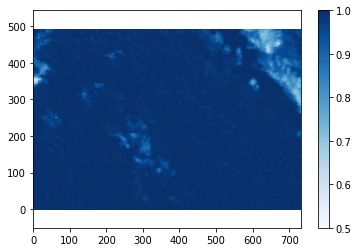

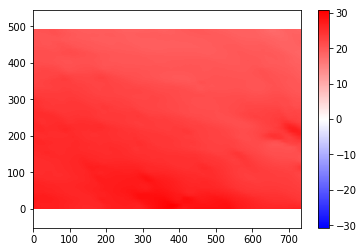

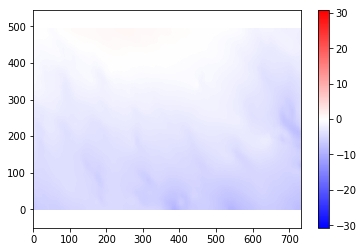

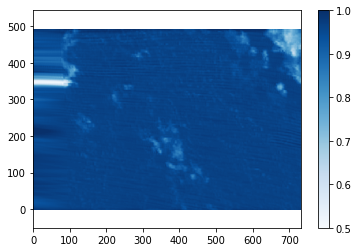

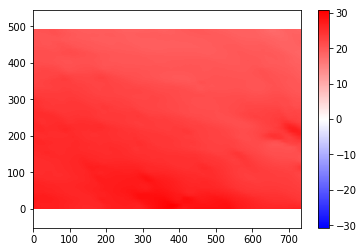

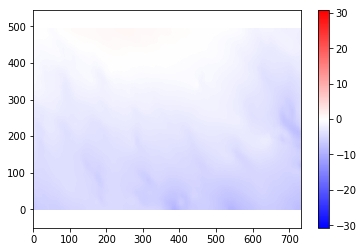

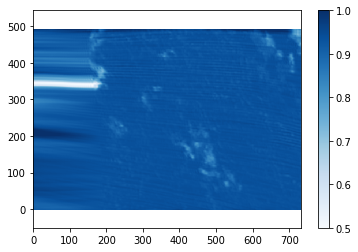

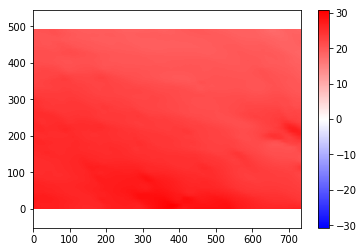

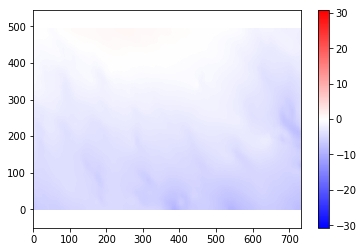

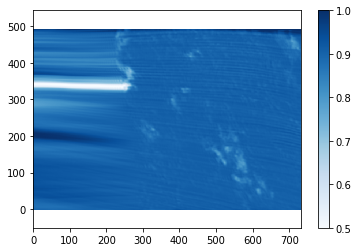

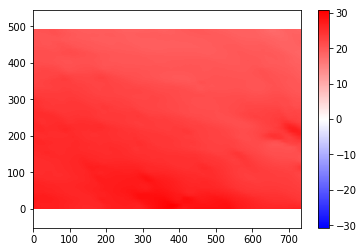

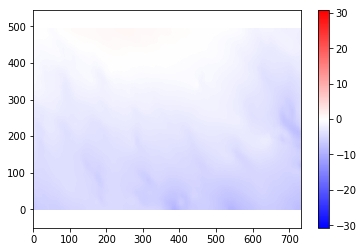

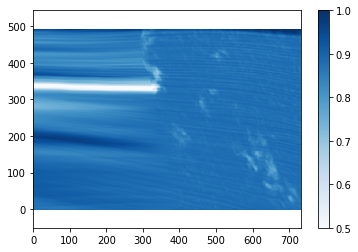

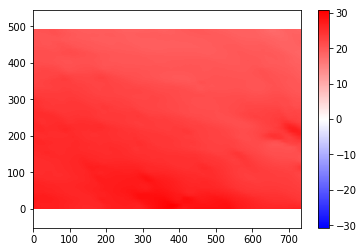

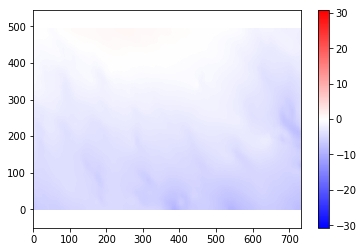

In [131]:
for i in range(ci_mean.shape[0]):
    plt.figure()
    im = plt.pcolormesh(ci_mean[i], cmap='Blues', vmin=.5, vmax=1)
    plt.colorbar(im)
    plt.axis('equal')
    
    vmax = np.max([np.abs(U[i]).max(), np.abs(V[i]).max()])
    plt.figure()
    im = plt.pcolormesh(U[i], cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    plt.axis('equal')
   
    plt.figure()
    im = plt.pcolormesh(V[i], cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    plt.axis('equal')

In [181]:
# make metadata should probably be more here: ci:interp method; winds: smoothing, level series
ci_metadata = {'shape':domain_shape, 'crop_shape':crop_shape, 'dx':250, 'dy':250}
u_metadata = {'shape':U_shape, 'crop_shape':U_crop_shape}
v_metadata = {'shape':V_shape, 'crop_shape':V_crop_shape}

NameError: name 'domain_shape' is not defined

In [ ]:
with pd.HDFStore(file_path_ci, mode='w', complevel=4) as store:
    store.put('ci', csi.T, format='table')
    store.put('x', pd.Series(x_sat))
    store.put('y', pd.Series(y_sat))
    store.put('crop_cols', pd.Series(flat_crop_indicies))
    store.put('metadata', pd.Series(ci_metadata))

In [ ]:
with pd.HDFStore(file_path_winds, mode='w', complevel=4) as store:
    store.put('U', U_smooth.T, format='table')
    store.put('V', V_smooth.T, format='table')
    store.put('U_crop_cols', pd.Series(flat_crop_indicies_U))
    store.put('V_crop_cols', pd.Series(flat_crop_indicies_V))
    store.put('U_metadata', pd.Series(u_metadata))
    store.put('V_metadata', pd.Series(v_metadata))

In [ ]:
with pd.HDFStore(file_path_ci, mode='r', complevel=4) as store:
    this = np.array(store.select(
        'ci', columns=[this_date], where=['index=flat_crop_indicies']))
    plt.figure()
    plt.pcolormesh((this.reshape(crop_shape)), cmap='Blues')
    plt.axis('equal')

In [ ]:
np.ravel_multi_index()

In [ ]:
 s = (f"this is {a} very"
      f"long stri{a}ng too"
      "for sure ..."
     )

In [ ]:
s

In [ ]:
with pd.HDFStore('/home2/travis/results/2014/05/29/run000/results.h5') as store:
#     print(store)
    print(store['param_dic'])
    this = store['MST1215_ci']
    for col in this.columns:
        plt.figure()
        plt.pcolormesh(this[col].reshape(crop_shape), cmap='Blues')
        plt.axis('equal')

In [ ]:
store.put('ensemble_15', ensemble_15)
store.put('ensemble_30', ensemble_30)
store.put('ensemble_45', ensemble_45)
store.put('ensemble_60', ensemble_60)
store.put('ensemble_analy', ensemble_analy)

In [ ]:
ensemble_15.to_hdf('./results/letkf_wind_2/ensemble_15.h5', 'ensemble_15', complevel=4)
ensemble_30.to_hdf('./results/letkf_wind_2/ensemble_30.h5', 'ensemble_30', complevel=4)
ensemble_45.to_hdf('./results/letkf_wind_2/ensemble_45.h5', 'ensemble_45', complevel=4)
ensemble_60.to_hdf('./results/letkf_wind_2/ensemble_45.h5', 'ensemble_60', complevel=4)
ensemble_analy.to_hdf('./results/letkf_wind_2/ensemble_analy.h5', 'ensemble_analy', complevel=4)    
# advected_15.to_hdf('./results/letkf_wind_2/advected_15.h5', 'advected_15')
# advected_30.to_hdf('./results/letkf_wind_2/advected_30.h5', 'advected_30')
# advected_45.to_hdf('./results/letkf_wind_2/advected_45.h5', 'advected_45')
np.save('./results/letkf_wind_2/ens_shape', ens_shape)
np.save('./results/letkf_wind_2/param_dic', param_dic)

In [ ]:
for i in range(10):
#     plt.figure()
#     plt.pcolormesh(csi.iloc[i][flat_crop_indicies].values.reshape(crop_shape))
#     plt.axes().set_aspect('equal')

#     plt.figure()
#     im = plt.pcolormesh(U_smooth.iloc[i][flat_crop_indicies_U].values.reshape(U_crop_shape))
#     plt.axes().set_aspect('equal')
#     plt.colorbar(im)
    
    plt.figure()
    im = plt.pcolormesh(V_smooth.iloc[i][flat_crop_indicies_V].values.reshape(V_crop_shape))
    plt.axes().set_aspect('equal')
    plt.colorbar(im)

In [ ]:
ensemble_15.to_hdf('./results/letkf_wind/ensemble_15.h5', 'ensemble_15')
ensemble_30.to_hdf('./results/letkf_wind/ensemble_30.h5', 'ensemble_30')
ensemble_45.to_hdf('./results/letkf_wind/ensemble_45.h5', 'ensemble_45')
ensemble_analy.to_hdf('./results/letkf_wind/ensemble_analy.h5', 'ensemble_analy')    
advected_15.to_hdf('./results/letkf_wind/advected_15.h5', 'advected_15')
advected_30.to_hdf('./results/letkf_wind/advected_30.h5', 'advected_30')
advected_45.to_hdf('./results/letkf_wind/advected_45.h5', 'advected_45')
np.save('./results/letkf_wind/ens_shape', ens_shape)
np.save('./results/letkf_wind/param_dic', param_dic)

In [ ]:
ensemble_15 = pd.read_hdf('./results/letkf_wind_long_bad/ensemble_15.h5', 'ensemble_15')
ensemble_30 = pd.read_hdf('./results/letkf_wind_long_bad/ensemble_30.h5', 'ensemble_30')
ensemble_45 = pd.read_hdf('./results/letkf_wind_long_bad/ensemble_45.h5', 'ensemble_45')
ensemble_analy = pd.read_hdf('./results/letkf_wind_long_bad/ensemble_analy.h5', 'ensemble_analy')    
advected_15 = pd.read_hdf('./results/letkf_wind_long_bad/advected_15.h5', 'advected_15')
advected_30 = pd.read_hdf('./results/letkf_wind_long_bad/advected_30.h5', 'advected_30')
advected_45 = pd.read_hdf('./results/letkf_wind_long_bad/advected_45.h5', 'advected_45')

In [ ]:
new_shape = (U_crop_shape[0], V_crop_shape[1])
this_u = U_crop.iloc[0].values.reshape(U_crop_shape)
this_v = V_crop.iloc[0].values.reshape(V_crop_shape)
# lf.remove_divergence()

In [ ]:
def ensemble_processing(ensemble, ens_shape, wind_size, error_indicies, truth):
    ens_mean = ensemble.mean(axis=1)
    ens_sd = np.sqrt(ensemble.var(axis=1))
    ens_error = (ens_mean[wind_size:] - truth)
    rmse = np.sqrt((ens_error[error_indicies]**2).mean())
    sd = np.sqrt((ens_sd[error_indicies + wind_size]**2).mean())
    sd_wind = None
    if wind_size != 0:
        sd_wind = np.sqrt((ens_sd[:wind_size]**2).mean())
    return ens_mean, ens_sd, ens_error, rmse, sd, sd_wind

In [ ]:
## ensemble calculations:
forecast_15_error = csi_crop.iloc[slice(1, None)]*np.nan
forecast_30_error = forecast_15_error.copy()
forecast_45_error = forecast_15_error.copy()
index = forecast_15_error.index
forecast_15_sd = pd.DataFrame(data=np.ones([index.size, ens_shape[0]])*np.nan,
                              index=index)
forecast_30_sd = forecast_15_sd.copy()
forecast_45_sd = forecast_15_sd.copy()
forecast_15 = forecast_15_sd.copy()
forecast_30 = forecast_15_sd.copy()
forecast_45 = forecast_15_sd.copy()
analysis = forecast_15.copy()
analysis_error = forecast_15_error.copy()
analysis_sd = forecast_15_sd.copy()
advected_15_error = forecast_15_error.copy()
advected_30_error = forecast_15_error.copy()
advected_45_error = forecast_15_error.copy()

col_names = ['fore_15', 'advected_15', 'fore_sd_15', 'fore_wind_sd_15', 
             'fore_30', 'advected_30', 'fore_sd_30', 'fore_wind_sd_30', 
             'fore_45', 'advected_45', 'fore_sd_45', 'fore_wind_sd_45',
             'analy', 'analy_sd', 'analy_wind_sd']                                                             
error_stats = pd.DataFrame(data=np.ones(len(col_names))[None, :]*np.nan,                                                     
                              index=[csi_crop.index[0]],                                                                        
                              columns=col_names)
wind_size = U_crop_size + V_crop_size
for time in csi_crop.index[1:]:
    sat = csi_crop.loc[time]
    if time in ensemble_analy.index:
        returned = ensemble_processing(
            ensemble_analy.loc[time].values.reshape(ens_shape),
            ens_shape, wind_size, flat_error_domain,
            csi_crop.loc[time])
        analysis.loc[time] = returned[0]
        analysis_sd.loc[time] = returned[1]
        analysis_error.loc[time] = returned[2]
        
        error_stats.loc[time, 'analy'] = returned[3]
        error_stats.loc[time, 'analy_sd'] = returned[4]
        error_stats.loc[time, 'analy_wind_sd'] = returned[5]
    if time in ensemble_15.index:
        returned = ensemble_processing(
            ensemble_15.loc[time].values.reshape(ens_shape),
            ens_shape, wind_size, flat_error_domain,
            csi_crop.loc[time])
        forecast_15.loc[time] = returned[0]
        forecast_15_sd.loc[time] = returned[1]
        forecast_15_error.loc[time] = returned[2]
        
        error_stats.loc[time, 'fore_15'] = returned[3]
        error_stats.loc[time, 'fore_sd_15'] = returned[4]
        error_stats.loc[time, 'fore_wind_sd_15'] = returned[5]
        
        advected_15_error.loc[time] = (
            advected_15.loc[time].values - csi_crop.loc[time])
        error_stats.loc[time, 'advected_15'] = np.sqrt(
            (advected_15_error.loc[time]
             .values[flat_error_domain]**2).mean())

            
    if time in ensemble_30.index:
        returned = ensemble_processing(
            ensemble_30.loc[time].values.reshape(ens_shape),
            ens_shape, wind_size, flat_error_domain,
            csi_crop.loc[time])
        forecast_30.loc[time] = returned[0]
        forecast_30_sd.loc[time] = returned[1]
        forecast_30_error.loc[time] = returned[2]
        
        error_stats.loc[time, 'fore_30'] = returned[3]
        error_stats.loc[time, 'fore_sd_30'] = returned[4]
        error_stats.loc[time, 'fore_wind_sd_30'] = returned[5]
        
        advected_30_error.loc[time] = (
            advected_30.loc[time].values - csi_crop.loc[time])
        error_stats.loc[time, 'advected_30'] = np.sqrt(
            (advected_30_error.loc[time]
             .values[flat_error_domain]**2).mean())

    
    if time in ensemble_45.index:
        returned = ensemble_processing(
            ensemble_45.loc[time].values.reshape(ens_shape),
            ens_shape, wind_size, flat_error_domain,
            csi_crop.loc[time])
        forecast_45.loc[time] = returned[0]
        forecast_45_sd.loc[time] = returned[1]
        forecast_45_error.loc[time] = returned[2]
        
        error_stats.loc[time, 'fore_45'] = returned[3]
        error_stats.loc[time, 'fore_sd_45'] = returned[4]
        error_stats.loc[time, 'fore_wind_sd_45'] = returned[5]
        
        advected_45_error.loc[time] = (
            advected_45.loc[time].values - csi_crop.loc[time])
        error_stats.loc[time, 'advected_45'] = np.sqrt(
            (advected_45_error.loc[time]
             .values[flat_error_domain]**2).mean())

forecast_15.dropna(inplace=True)
forecast_30.dropna(inplace=True)
forecast_45.dropna(inplace=True)
forecast_15_sd.dropna(inplace=True)
forecast_30_sd.dropna(inplace=True)
forecast_45_sd.dropna(inplace=True)
forecast_15_error.dropna(inplace=True)
forecast_30_error.dropna(inplace=True)
forecast_45_error.dropna(inplace=True)
analysis.dropna(inplace=True)
analysis_error.dropna(inplace=True)
analysis_sd.dropna(inplace=True)
advected_15_error.dropna(inplace=True)
advected_30_error.dropna(inplace=True)
advected_45_error.dropna(inplace=True)

In [ ]:
ymax=None
to_plot = ['fore_15', 'advected_15', 'fore_sd_15', 'analy', 'analy_sd'] # 
# to_plot = ['fore_15', 'advected_15']
error_stats[to_plot].dropna().plot(marker='.')
plt.ylim([0, ymax])
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Clear Sky Index')
plt.title('Forecast Horizon of 15 minutes')
# plt.legend(['Forecast RMSE', 'Smoothed WRF RMSE', 'Forecast sd', 'Analysis RMSE', 'Analysis sd'])

In [ ]:
ymax=None
# to_plot = ['fore_15', 'advected_15', 'fore_sd_15', 'analy', 'analy_sd'] # 
to_plot = ['fore_wind_sd_15', 'analy_wind_sd']
error_stats[to_plot].dropna().plot(marker='.')
plt.ylim([0, ymax])
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Clear Sky Index')
plt.title('Forecast Horizon of 15 minutes')
# plt.legend(['Forecast RMSE', 'Smoothed WRF RMSE', 'Forecast sd', 'Analysis RMSE', 'Analysis sd'])

In [ ]:
vmax = None
vmin = None
for this_time in range(forecast_15.index.size):
#     plt.figure()
#     im = plt.pcolormesh(
#             forecast_15.iloc[this_time]
#             .values[:U_crop_size].reshape(U_crop_shape), cmap='Greys')
#     plt.colorbar(im)

    plt.figure()
    im = plt.pcolormesh(
        forecast_15.iloc[this_time]
        .values[U_crop_size: U_crop_size + V_crop_size]
        .reshape(V_crop_shape), cmap='Greys', vmax=vmax, vmin=vmin)
    plt.colorbar(im)

In [ ]:
this_time = '2014-05-29 10:15'
plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[this_time]
        .values[wind_size:].reshape(crop_shape), cmap='Blues',
)#vmin=0, vmax=1)
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        advected_15.loc[this_time]
        .values.reshape(crop_shape), cmap='Blues',
)#vmin=0, vmax=1)
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        csi_crop.loc[this_time]
        .values.reshape(crop_shape), cmap='Blues')
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[this_time]
        .values[:U_crop_size].reshape(U_crop_shape), cmap='Greys')
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[this_time]
        .values[U_crop_size: U_crop_size + V_crop_size].reshape(V_crop_shape), cmap='Greys')
plt.colorbar(im)


In [ ]:
this_time = '2014-05-29 12:45:00-07:00'
this = ensemble_15.loc[this_time].values.reshape(ens_shape).mean(axis=1)
this_U = this[:U_crop_size].reshape(U_crop_shape)
this_V = this[U_crop_size:U_crop_size + V_crop_size].reshape(V_crop_shape)
this_csi = this[U_crop_size + V_crop_size:].reshape(crop_shape)

In [ ]:
plt.figure()
plt.pcolormesh(this_csi, cmap='Blues', vmin=0, vmax=1)

plt.figure()
plt.pcolormesh(csi_crop.loc[this_time].values.reshape(crop_shape),
               cmap='Blues', vmin=0, vmax=1)

# vmax = 30
# plt.figure()
# plt.pcolormesh(this_U, vmin=-vmax, vmax=vmax)

# plt.figure()
# plt.pcolormesh(this_V, vmin=-vmax, vmax=vmax)

In [ ]:
import matplotlib.colors as colors

In [ ]:
vmin = 0
vmax = 1
nc = 11
bounds = np.linspace(vmin, vmax, nc)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
count=0
dpi = 100
for this_time in ensemble_movie.index:
    mean = ensemble_movie.loc[this_time].values.reshape(ens_shape)
    member1 = mean[2:, 0].reshape(crop_shape)
    member2 = mean[2:, 1].reshape(crop_shape)
    member3 = mean[2:, 2].reshape(crop_shape)
    mean = mean.mean(axis=1)[2:]
    mean = mean.reshape(crop_shape)
    
    plt.figure()
    im = plt.pcolormesh(mean, cmap='Blues', norm=norm)
    plt.colorbar(im, label='CSI')
    plt.xlim([100, None])
    plt.axis('off')
    
    plt.savefig('./movies/ens_mean_movie/zfig{0:04}.png'.format(count),
               format='png', dpi=dpi)
    count += 1
#     plt.close('all')
    
#     plt.figure()
#     im = plt.pcolormesh(member3, cmap='Blues', norm=norm)
#     plt.colorbar(im, label='CSI')
#     plt.xlim([100, None])
#     plt.axis('off')
    

    
#     plt.figure()
#     plt.pcolormesh(member1, cmap='Blues', vmin=0, vmax=1)
#     plt.xlim([100, None])
#     plt.title(this_time)

In [ ]:
plt.close('all')

In [ ]:
import tmh_plot

In [ ]:
importlib.reload(tmh_plot)

vmin = 0
vmax = 1
nc = 15
bounds = np.linspace(vmin, vmax, nc)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
count=0
dpi = 100
for this_time in ensemble_movie.index:
    this_ensemble = ensemble_movie.loc[this_time].reshape(ens_shape)[2:]
    # this_other = [clouds.ravel()]
    # other_titles = ['Original']
    this_other = []
    other_titles = []
    nrows = 2
    ncols = 2
    adjust = .82
    fig, ax = tmh_plot.ensemble_stamps(others=this_other, other_titles=other_titles,
                             ensemble=this_ensemble, nrows=nrows,
                             ncols=ncols, domain_shape=crop_shape, adjust=adjust)
    fig.savefig('./movies/ens_movie/zfig{0:04}.png'.format(count),
                format='png', dpi=dpi)
    count += 1

In [ ]:
this_time = '2014-05-29 12:15'
that_time = '2014-05-29 12:00'
plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[that_time]
        .values[:U_crop_size].reshape(U_crop_shape), cmap='Greys')
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[this_time]
        .values[:U_crop_size].reshape(U_crop_shape), cmap='Greys')
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[that_time]
        .values[U_crop_size: U_crop_size + V_crop_size].reshape(V_crop_shape), cmap='Greys')
plt.colorbar(im)

plt.figure()
im = plt.pcolormesh(
        forecast_15.loc[this_time]
        .values[U_crop_size: U_crop_size + V_crop_size].reshape(V_crop_shape), cmap='Greys')
plt.colorbar(im)

In [ ]:
# ORIGINAL
#%%timeit -n1 -r1
## Assimilation only of sat to sat
time0 = time.time()
## Try to use a seperate sigma for wind assimilation
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 5 #was 1
localization_letkf = 2*4
sat_inflation = 1.5
wind_inflation = 4
wind_sat_sig = 1

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.05 #0.01 <- sd<rmse
ens_size = 38 #was 40
wind_sigma = (1.8, 1.8) #(1.5, 1.5)
wind_size = 2
CI_sigma = .2

pert_sigma = 0.12/3 # 0.10/3
pert_mean = 0 # -0.02/3 # 0, 0.05, 0.01
edge_weight = 1

# works: const - 3 (2, 2) .2, 0.01, loc: 1
# start_time = None
# end_time = None
start_time = '2014-05-29 14:00:00' #11:00:00 is not a bad start
end_time = '2014-05-29 15:00:00' #Gets boring shortly after 14:00:00

# U_corrected = U_const # - 3
# V_corrected = V_const

U_corrected = U_crop
V_corrected = V_crop

returned = lf.main_only_sat(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_corrected, U_shape=U_crop_shape, V=V_corrected, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,
    CI_sigma=CI_sigma,
    client=client, flat_error_domain=flat_error_domain,
    wind_inflation=wind_inflation,
    wind_sat_sig=wind_sat_sig,
    pert_sigma=pert_sigma, pert_mean=pert_mean,
    rf_eig=e, rf_vectors=v, rf_approx_var=approx_var,
    edge_weight=edge_weight)
ensemble_15, ensemble_30, ensemble_45 = returned[0:3]
ensemble_analy, ens_shape = returned[3:5]
advected_15, advected_30, advected_45 = returned[5:8]

time1 = time.time()
print('It took: ' + str((time1 - time0)/60))

In [ ]:
print('It took: ' + str((time1 - time0)/60))

In [ ]:
plt.figure()
plt.pcolormesh(advected_15.iloc[1].values[flat_error_domain].reshape(error_domain_shape), cmap='Blues')

plt.figure()
plt.pcolormesh(advected_30.iloc[1].values[flat_error_domain].reshape(error_domain_shape), cmap='Blues')

plt.figure()
plt.pcolormesh(advected_45.iloc[1].values[flat_error_domain].reshape(error_domain_shape), cmap='Blues')

In [ ]:
suffix = '_{month}_{day}'.format(month=month, day=day)
file = './data/for' + suffix + '/' + 'results_pert/'
if not os.path.exists(file):
    os.mkdir(file)
file = file + '{var}'

In [ ]:
ensemble_15.to_hdf(file.format(var='ensemble_15.h5'), 'ensemble_15')
ensemble_30.to_hdf(file.format(var='ensemble_30.h5'), 'ensemble_30')
ensemble_45.to_hdf(file.format(var='ensemble_45.h5'), 'ensemble_45')
ensemble_analy.to_hdf(file.format(var='ensemble_analy.h5'), 'ensemble_analy')
advected_15.to_hdf(file.format(var='advected_15.h5'), 'advected_15')
advected_30.to_hdf(file.format(var='advected_30.h5'), 'advected_30')
advected_45.to_hdf(file.format(var='advected_45.h5'), 'advected_45')
np.save(file.format(var='ens_shape'), ens_shape)
np.save(file.format(var='flat_crop_indicies'), flat_crop_indicies)